In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, colormaps
import ipywidgets

In [2]:
# Give initial parameters to generate the probe
pixel_size = 0.1 # All units are in angstroms for computational simulations
im_shape = (512,512) # Pixel array size
probe_mrads = 20 # Max alpha
wavl = 0.02 # Wavelength (angstroms) Corresponds to ~300keV


In [3]:
# Make the coordinates
# Coordinates
kx = np.fft.fftfreq(im_shape[0], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
ky = np.fft.fftfreq(im_shape[1], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
kr2 = kx[:,None]**2+ky[None,:]**2
kr = kr2**0.5

# Probe
k_max = probe_mrads/1000/wavl
# Psi0 = kr < k_max
Psi0 = np.clip((k_max-kr)/(kx[1]-kx[0])+0.5,0,1)


psi0 = np.fft.ifft2(Psi0)
# defocus = 
print(k_max)

1.0


In [4]:
def genMaskF(shape,f):
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    
    
    # Create Mask
    return np.logical_and(
        np.mod(x[:,None],f) == 0,
        np.mod(y[None,:],f) == 0,
    )

(192.0, 320.0)

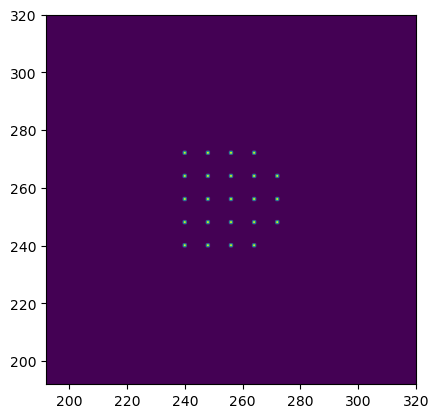

In [ ]:
def generateSpiralCoordinateArray(Psi0downsampled):
    mask = np.fft.fftshift(Psi0downsampled) > 0 # Center and Select for non zero spatial frequencies

    # Get a list of the coordinates of those points
    xy = np.argwhere(mask)

    # Take the (n,2) array and calculate the center by getting the mean of points
    xy_centered = xy - np.mean(xy,axis = 0) # Calculate 

    # Calculate the radius and angle of each of the points
    r = np.sqrt(np.sum(xy_centered**2,axis = 1))
    t = np.arctan2(xy_centered[:,1],xy_centered[:,0])

    vals = r + t*0.1 # Start with radius and add a small amount dependent on angle to enable sort
    inds = np.argsort(vals) # Get an array of sorted positions coresponding to the spiral order
    return xy, inds # Return the spiral order


    
f = 8
Psi0downsampled = Psi0*genMaskF(np.shape(Psi0), f)
xy, inds = generateSpiralCoordinateArray(Psi0downsampled)
im = np.zeros(im_shape)
fig,ax = plt.subplots()
num = 23
inds_plot = inds[:num]
im[xy[inds_plot,0],xy[inds_plot,1]] = 1

spiralCoords = xy[inds]

ax.imshow(np.real(im))
ax.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
ax.set_ylim(im_shape[0]/2-64,im_shape[0]/2+64)


In [6]:
def genSpatialFrequencyArrayV2(im_shape,coordinates = False):
    h,w = im_shape
        
    planeWaveStack = np.zeros((np.shape(coordinates)[0],h,w),np.complex128)
    array = np.zeros((h,w))

    for i in range(np.shape(coordinates)[0]):
        array *= 0
        (x,y) = coordinates[i,:]
        # print(f"{x}, {y}")
        array[x][y] = 1
        planeWaveStack[i,:,:] = np.fft.fft2(np.fft.fftshift(array))
    return planeWaveStack
# print(np.shape(spiralCoords))
planeWaveStack = genSpatialFrequencyArrayV2(im_shape, spiralCoords)

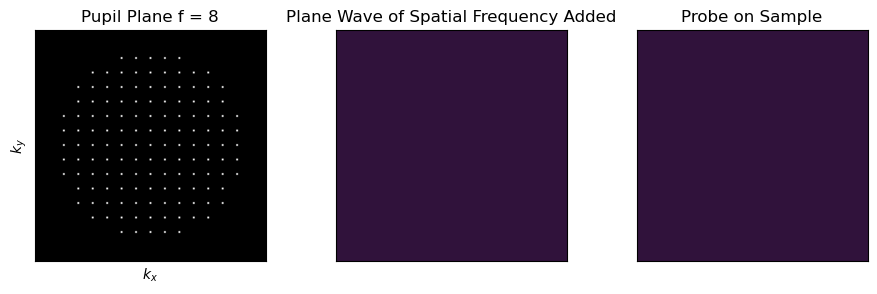

In [7]:
image_array = planeWaveStack
coords = spiralCoords
# Create the figure and axis
probeTotal = np.zeros(np.shape(Psi0downsampled),dtype=np.complex128)
pupilTotal = np.zeros(np.shape(Psi0downsampled))
fig, ax = plt.subplots(1,3,figsize=(11,3))
ax1,ax2,ax3 = ax
# Update function for animation
def update(frame):
    # Make a display of where each spatial frequency came
    if frame >= len(image_array):
        pass
    else:
        pupilTotal[:frame] = np.nan
        cmap = colormaps.get_cmap('gray')
        cmap.set_bad("red")
        ax1.clear()
        ax1.imshow(pupilTotal, cmap=cmap)
        ax1.set_title(f"Pupil Plane f = 8")
        ax1.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
        ax1.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
        ax1.set_ylabel("$k_{y}$")
        ax1.set_xlabel("$k_{x}$")
        ax1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        # print(f"{coords[0][frame]}, {coords[1][frame]} ")
        
        ax2.clear()
        ax2.imshow(np.real(image_array[frame]), cmap='turbo')
        ax2.set_title(f"Plane Wave of Spatial Frequency Added")
        ax2.set_xlim(0,im_shape[0])
        ax2.set_ylim(1,im_shape[0])
        ax2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        
        # Add the probe to the total
        ax3.clear()
        ax3.imshow(np.real(np.sum(planeWaveStack[:frame],0)), cmap='turbo')
        ax3.set_title(f"Probe on Sample")
        ax3.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
        if frame >= len(image_array)/4:
            ax3.set_title(f"Zoomed in Probe on Sample")
            ax3.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
            ax3.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
        pupilTotal[(coords[frame][0], coords[frame][1])] = 1
    return ax,

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(image_array)+10, interval=200, blit=False)

# Save the animation as a GIF
anim.save('probe_construction.gif', writer='pillow', fps=4)

In [8]:
import io
# Define the constants required to enable the update functions
image_array = planeWaveStack
coords = spiralCoords

pupilTotal = np.zeros(np.shape(Psi0downsampled))

def update_probe_construction_figure(frame):
    """ This is a update function that relies on a set of coordinates for the spiral
    input as well as a stack of plane waves associated with the spiral coordinates. To create
    the plot of a probe slowly being constructed from each of the spatial frequencies.
    
    
    Keyword arguments:
    argument -- description
    Return: return_description
    """
    
    # Generate a function
    fig,ax = plt.subplots(1,3,figsize=(11,3))
    ax1,ax2,ax3 = ax
    
    # Generate the Total Pupil
    pupilTotal[:,:] = 0
    pupilTotal[coords[:frame,0],coords[:frame,1]] = 1
    pupilTotal[coords[frame,0],coords[frame,1]] = np.nan
    
    
    # Sum plane waves
    probeTotal = np.sum(planeWaveStack[:frame],0)
    
    # Plot 1 and Formating
    ax1.clear()
    cmap = colormaps.get_cmap('gray')
    cmap.set_bad("red")
    ax1.imshow(pupilTotal, cmap=cmap)
    ax1.set_title(f"Pupil Plane f = 8")
    ax1.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
    ax1.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
    ax1.set_ylabel("$k_{y}$")
    ax1.set_xlabel("$k_{x}$")

    ax2.clear()
    ax2.imshow(np.real(image_array[frame]), cmap='turbo')
    ax2.set_title(f"Plane Wave of Spatial Frequency Added")
    ax2.set_xlim(0,im_shape[0])
    ax2.set_ylim(0,im_shape[1])
        
    ax3.clear()
    ax3.imshow(np.abs(probeTotal), cmap='turbo')
    ax3.set_title(f"Probe on Sample")
    if frame > 25:
        ax3.set_title(f"Zoomed in Probe on Sample")
        ax3.set_xlim(im_shape[0]/2-64,im_shape[0]/2+64)
        ax3.set_ylim(im_shape[1]/2-64,im_shape[1]/2+64)
    else:
        ax3.set_xlim(0,im_shape[0])
        ax3.set_ylim(0,im_shape[1])
    
    
    ax1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
    ax2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
    ax3.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 

    
    # Convert plot to PNG image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return buf.getvalue()



In [9]:
import ipywidgets as widgets

num_frames = planeWaveStack.shape[0]
fps = 2

# Create image widget
image_widget = widgets.Image(
    value=update_probe_construction_figure(0),
    format='png',
)

# Create frame slider
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=num_frames-1,
    description='Spatial Frequencies Added:',
    continuous_update=False,  # Only update when slider is released
    style = {'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

# Create play button
play_button = widgets.Play(
    value=0,
    min=0,
    max=num_frames-1,
    step=1,
    interval=1000//fps,
    description="Play"
)

# Link play button to slider
widgets.jslink((play_button, 'value'), (frame_slider, 'value'))

# Update image when slider changes
def update_image(change):
    image_widget.value = update_probe_construction_figure(change.new)

frame_slider.observe(update_image, names='value')

# Create controls container
controls = widgets.HBox([play_button, frame_slider])

# Combine everything into a single widget
player = widgets.VBox([controls,image_widget])



# Probe Construction

In [10]:


display(player)

In [11]:
# Recode the image method with 
# im.set_data(array) # Version